# Explorative Data Analysis
## Introduction
This master thesis investigates time-stamped observability signals collected from the infrastructure (platform) Kubernetes cluster, focusing on numeric metrics (Prometheus) and textual logs (Loki). Signals are ingested via an observability pipeline using the OpenTelemetry Collector to gather, transform, and ship data to centralized storage. A simplified architecture of this pipeline is depicted below.

![observability-signals-pipeline](./img/observability-signals-pipeline.png)

Given the distributed nature of Kubernetes and the complexity of the ingestion pipeline, some observations may be missing. Throughout this study, missing observations are treated as absence of data rather than null values. In practice, Prometheus and Loki do not ingest explicit nulls; therefore, we assume that when a series or stream is present, it contains concrete values, and when absent, the issue likely originates from upstream collection, transport, or storage components.

## Scope and Objectives
- Characterize the structure and statistical properties of Prometheus metrics (numeric time series) and Loki logs (string-valued events) produced by platform services (observability stack, authentication/authorization, CI/CD tooling, ingress, and related system components).
- Quantify label distributions, cardinalities, and patterns across infrastructure namespaces, service classes, and workload types (excluding product/application namespaces).
- Provide guidance for feature engineering and model-ready representations tailored to infrastructure reliability and operations analytics.
- Explicitly exclude application/product workloads and business-domain metrics/logs; the analysis is limited to the infrastructure cluster.

## Data Characteristics
Observations in both systems are associated with a timestamp, a set of labels and a value. For Prometheus, values are numeric (integer or float), representing counters, gauges, or derived rates. For Loki, values are strings whose formats depend on application logging conventions (e.g., JSON, logfmt, or plaintext). Labels encode contextual metadata (e.g., namespace, pod, container, component), enabling grouping and filtering across heterogeneous platform services. Limiting scope to infrastructure services focuses the analysis on platform reliability, resource utilization, and systemic health signals rather than application-level semantics.

# Exploration
In the following sections, we examine Prometheus and Loki data currently stored in the production infrastructure environment. We first describe their data models and labeling schemes, then perform exploratory analyses of volumes, cardinalities, temporal dynamics, and representative samples. These results inform subsequent preprocessing steps and the selection of robust features for downstream data science tasks.

## Prometheus


Below we summarize the number of time series per metric name returned by the earlier query (infrastructure cluster and monitoring namesapce constrained). We examine:
- Absolute counts sorted descending (Top-N focus).
- Long tail characteristics via cumulative coverage.
- Log-scaled distribution to highlight smaller metrics.
These views help identify high-cardinality or high-volume metric families (e.g., HTTP server buckets) and very low-volume control/process metrics (e.g., OpenTelemetry collector internals).


In [1]:
# import libraries
import pandas as pd
from prometheus_api_client import PrometheusConnect
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


In [4]:
# configure Prometheus connection and test it
prom = PrometheusConnect(url='http://localhost:3001', disable_ssl=True)
print("Connected to Prometheus:", prom.check_prometheus_connection())

Connected to Prometheus: True


### Time-Series

In [15]:
# Query metric count by name 
query_metric_names = prom.custom_query(query='count by (__name__) ({__name__!="",cluster=~".*infra"})')
metric_names = {}
for entry in query_metric_names:
    metric_names[entry['metric']['__name__']] = entry['value'][1]

In [32]:
# Build DataFrame from metric_names and display
metric_df = (pd.Series(metric_names, name='count')
              .astype(int)
              .rename_axis('metric')
              .reset_index()
              .sort_values('count', ascending=False))

# Compute cumulative coverage and show head
total = metric_df['count'].sum()
metric_df['cumulative'] = metric_df['count'].cumsum() / total

print(f'Total metrics: {len(metric_df)}')
print(f'Total timeseries across metrics: {total}')
metric_df.head()

Total metrics: 2885
Total timeseries across metrics: 256726


,metric,count,cumulative
1717,loki_tsdb_shipper_table_sync_latency_seconds_b...,19992,0.077873
1714,loki_tsdb_shipper_query_wait_time_seconds_bucket,19992,0.155746
32,azure_api_service_uptime,19792,0.232840
31,azure_api_service_status,19792,0.309934
2126,prober_probe_duration_seconds_bucket,3012,0.321666


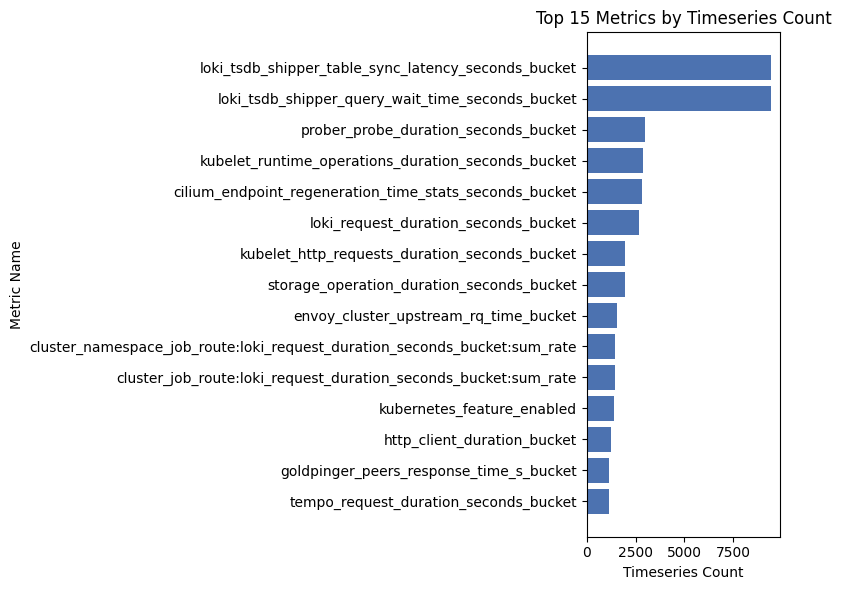

In [101]:
# Plot 1: Top-N absolute counts
top_n = 15
top_df = metric_df.head(top_n)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(top_df['metric'][::-1], top_df['count'][::-1], color='#4C72B0')
ax.set_title(f'Top {top_n} Metrics by Timeseries Count')
ax.set_xlabel('Timeseries Count')
ax.set_ylabel('Metric Name')
plt.tight_layout()
plt.show()

In this initial exploration of the Prometheus data, we observe a broad spectrum of available metrics and time series that could serve as candidate inputs for the modeling tasks in this thesis. As the analysis progresses, we narrow our focus to a set of aggregated, infrastructure-level indicators of service health (e.g., CPU and memory utilization, network traffic) that provide stable and interpretable signals across platform components.

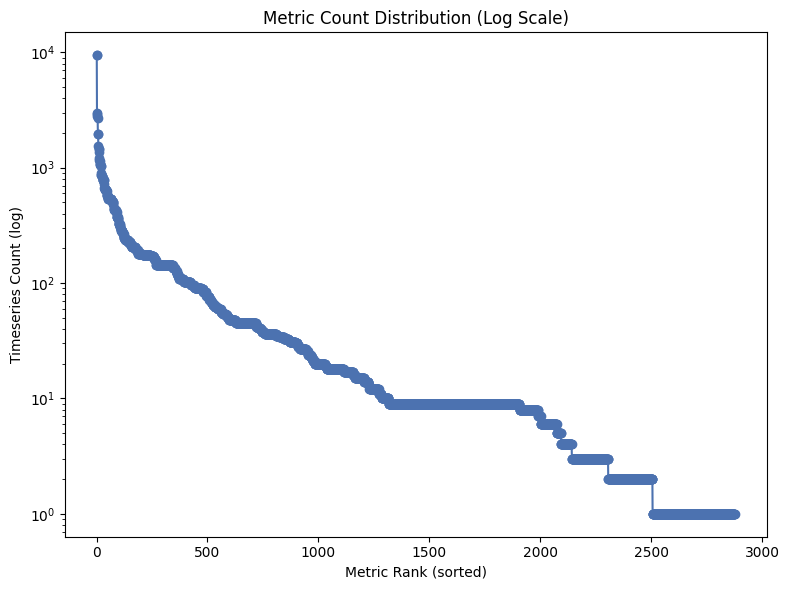

In [102]:
# Plot 2: Full distribution (log scale)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(metric_df['count'].values, marker='o', linestyle='-', color='#4C72B0')
ax.set_yscale('log')
ax.set_title('Metric Count Distribution (Log Scale)')
ax.set_xlabel('Metric Rank (sorted)')
ax.set_ylabel('Timeseries Count (log)')
plt.tight_layout()
plt.show()

The distribution of time series across metric names is highly uneven. This pattern is partly driven by services such as Loki, which expose separate series for each index and latency bucket (for example, 0.025, 0.05, 0.5, 1 seconds for synchronous operations). In a production feature set, many of these fine-grained bucketed metrics would typically be aggregated or filtered; however, they are retained here to highlight the breadth of available observability data and its potential for future development and research.

Based on prior operational experience, several metric families emerge as generally valuable indicators of service health, including:
- CPU usage metrics (e.g., `node_namespace_pod_container:container_cpu_usage_seconds_total:sum_irate`),
- CPU throttling (`container_cpu_cfs_throttled_periods_total`),
- Memory utilization metrics (`container_memory_working_set_bytes`),
- Configured CPU and memory requests and limits.

In addition, node-level metrics from the servers on which Kubernetes and the infrastructure services run provide critical context for reliability analysis and model training. The Prometheus [node-exporter](https://github.com/prometheus/node_exporter) exposes a comprehensive set of host metrics covering CPU, memory, and disk usage as well as network traffic, filesystem characteristics, and related signals. These metrics can be subjected to anomaly detection as part of root cause analysis workflows, helping to surface subtle patterns that might be missed by manual inspection alone.

### Labels
We analyze label cardinality to understand metadata diversity and potential sources of high series counts. Specifically, we:
- List available label keys from Prometheus.
- Compute unique value counts per label (cardinality).
- Highlight top-N labels by cardinality and discuss implications for storage and query performance.


In [ ]:
# Fetch label names and compute cardinality
label_names = prom.get_label_names()

label_cardinality = {}
for label_name in label_names:
    try:
        values = prom.get_label_values(label_name)
        # Deduplicate and count
        label_cardinality[label_name] = len(set(values))
    except Exception as e:
        # Skip labels that error out
        continue

label_df = (pd.Series(label_cardinality, name='unique_values')
             .rename_axis('label')
             .reset_index()
             .sort_values('unique_values', ascending=False))

print(f'Total labels: {len(label_df)}')
label_df.head(20)

Total labels: 601


,label,unique_values
491,service_name,35373
213,id,22267
91,container_id,17794
303,name,16244
557,uid,14407
367,pod,13303
13,address,11687
119,device,10803
229,interface,9702
301,mountpoint,9468


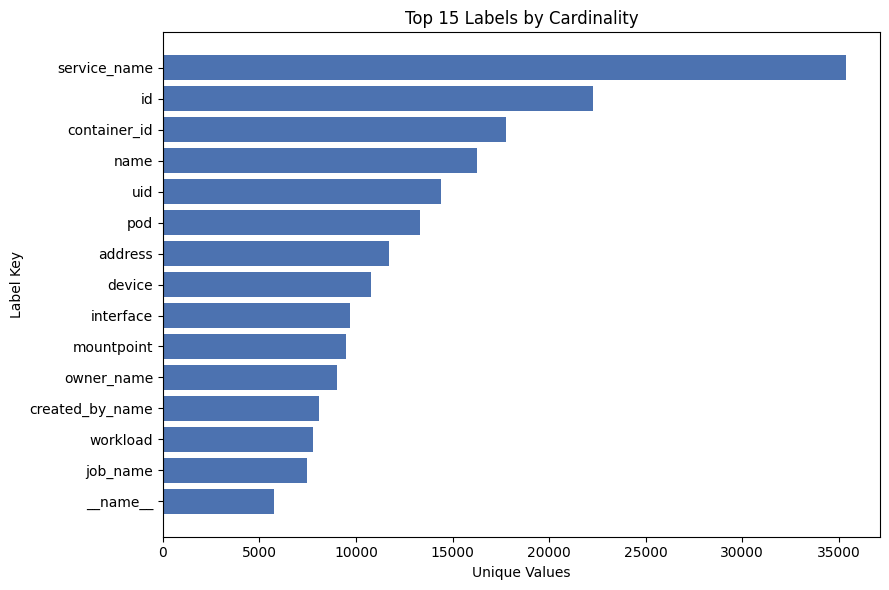

In [105]:
# Plot top-N labels by cardinality
top_n_labels = 15
top_labels_df = label_df.head(top_n_labels)

fig, ax = plt.subplots(figsize=(9, 6))
ax.barh(top_labels_df['label'][::-1], top_labels_df['unique_values'][::-1], color='#4C72B0')
ax.set_title(f'Top {top_n_labels} Labels by Cardinality')
ax.set_xlabel('Unique Values')
ax.set_ylabel('Label Key')
plt.tight_layout()
plt.show()

In [ ]:
## Label Co-Occurrence (Heatmap)

# Sample series from top metrics
sample_metrics = metric_df['metric'].head(8).tolist()
series_labels = []
for m in sample_metrics:
    series = prom.custom_query(query=f'{{__name__="{m}"}}')
    for s in series:
        labels = set(k for k in s.get('metric', {}).keys() if k != '__name__')
        if labels:
            series_labels.append(labels)

# Build co-occurrence matrix
from itertools import combinations
import pandas as pd
all_labels = sorted(set().union(*series_labels)) if series_labels else []
cooc = pd.DataFrame(0, index=all_labels, columns=all_labels, dtype=int)

for lbls in series_labels:
    for a, b in combinations(sorted(lbls), 2):
        cooc.loc[a, b] += 1
        cooc.loc[b, a] += 1
    # Self-occurrence as presence count
    for a in lbls:
        cooc.loc[a, a] += 1

# Plot heatmap
if len(all_labels) > 0:
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(max(8, 0.6 * len(all_labels)), max(6, 0.6 * len(all_labels))))
    im = ax.imshow(cooc.values, cmap='Purples', aspect='auto')
    ax.set_xticks(range(len(all_labels)))
    ax.set_yticks(range(len(all_labels)))
    ax.set_xticklabels(all_labels, rotation=45, ha='right')
    ax.set_yticklabels(all_labels)
    ax.set_title('Label Co-Occurrence Across Sampled Series')
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Co-Occurrence Count')
    plt.tight_layout()
    plt.show()
else:
    print('No label data available to compute co-occurrence.')

# Conclusion
After shorty examining some basic Prometheus data it was concluded that this data cannot be shared since it contains some sensible company data. This will not be the case for future work since the data will be filtered. 